# Preamble

In [1]:
import os, sys, glob
import pandas as pd
import numpy as np
import scipy as sp
from scipy import stats
import scipy.io as sio
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
sys.path.append('/Users/lindenmp/Dropbox/Work/ResProjects/NormativeNeuroDev_CrossSec_T1/code/func/')
from proj_environment import set_proj_env
from func import mark_outliers, winsorize_outliers_signed

In [3]:
train_test_str = 'squeakycleanExclude'
exclude_str = 't1Exclude' # 't1Exclude' 'fsFinalExclude'
parc_str = 'schaefer' # 'schaefer' 'lausanne'
parc_scale = 400 # 200 400 | 60 125
extra_str = '_no_wins'
parcel_names, parcel_loc, drop_parcels, num_parcels, yeo_idx, yeo_labels = set_proj_env(train_test_str = train_test_str, exclude_str = exclude_str,
                                                                            parc_str = parc_str, parc_scale = parc_scale, extra_str = extra_str)

### Setup output directory

In [4]:
print(os.environ['MODELDIR_BASE'])
print(os.environ['MODELDIR'])
if not os.path.exists(os.environ['MODELDIR']): os.makedirs(os.environ['MODELDIR'])

/Users/lindenmp/Dropbox/Work/ResProjects/NormativeNeuroDev_CrossSec_T1/analysis/normative/t1Exclude/squeakycleanExclude/schaefer_400
/Users/lindenmp/Dropbox/Work/ResProjects/NormativeNeuroDev_CrossSec_T1/analysis/normative/t1Exclude/squeakycleanExclude/schaefer_400_no_wins


## Load data

In [5]:
# Load data
df = pd.read_csv(os.path.join(os.environ['MODELDIR_BASE'], 'df_pheno.csv'))
df.set_index(['bblid', 'scanid'], inplace = True)
print(df.shape)

(1100, 18)


In [6]:
# Load data
df_node = pd.read_csv(os.path.join(os.environ['MODELDIR_BASE'], 'df_node_base.csv'))
df_node.set_index(['bblid', 'scanid'], inplace = True)
print(df_node.shape)

(1100, 801)


In [7]:
df_node.head()

,,squeakycleanExclude,ct_0,ct_1,ct_2,ct_3,ct_4,ct_5,ct_6,ct_7,ct_8,...,gmd_390,gmd_391,gmd_392,gmd_393,gmd_394,gmd_395,gmd_396,gmd_397,gmd_398,gmd_399
bblid,scanid,,,,,,,,,,,,,,,,,,,,,
81287,2738,0,2.589331,2.376762,1.944943,2.008444,1.189349,2.500871,1.476793,2.427288,1.355330,...,0.562872,0.526196,0.528415,0.579123,0.577493,0.562220,0.556643,0.534894,0.460991,0.439700
80680,2739,1,2.996621,2.661491,2.124037,1.945934,1.798787,2.750110,2.207849,2.811127,2.141390,...,0.548591,0.535702,0.513437,0.540461,0.561123,0.496535,0.484950,0.560912,0.526287,0.474563
81754,2740,1,3.030051,3.096167,2.847334,2.503361,1.961650,2.970223,2.637141,2.641559,1.976462,...,0.487143,0.505065,0.477412,0.541836,0.551712,0.524803,0.528812,0.550941,0.565324,0.449353
81903,2749,0,2.938993,2.475715,2.280973,2.042745,1.492544,2.530109,1.580719,3.217708,2.184726,...,0.556357,0.532077,0.507555,0.555514,0.572792,0.535352,0.562016,0.552036,0.577172,0.473400
81043,2750,0,2.640287,1.900444,2.408298,1.600272,1.454706,2.261128,1.305181,3.392621,2.194686,...,0.560927,0.546880,0.524136,0.569827,0.562604,0.526262,0.563106,0.555723,0.462914,0.455674


# Plots

In [8]:
# Labels
sns.set(style='white', context = 'talk', font_scale = .8)

In [9]:
metrics = ('ct', 'gmd')
df_node_mean = pd.DataFrame(index = df_node.index, columns = metrics)
for metric in metrics:
    df_node_mean[metric] = df_node.filter(regex = metric, axis = 1).mean(axis = 1)

/Users/lindenmp/.virtualenvs/NeuroDev_NetworkControl/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


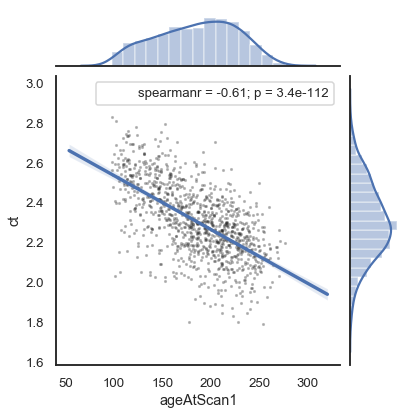

In [10]:
metric_x = 'ageAtScan1'
metric_y = 'ct'
f = sns.jointplot(x = df[metric_x], y = df_node_mean[metric_y], kind="reg")
f.annotate(sp.stats.spearmanr)
f.plot_joint(plt.scatter, c = "k", s = 5, linewidth = 2, marker = ".", alpha = 0.3)
f.ax_joint.collections[0].set_alpha(0)

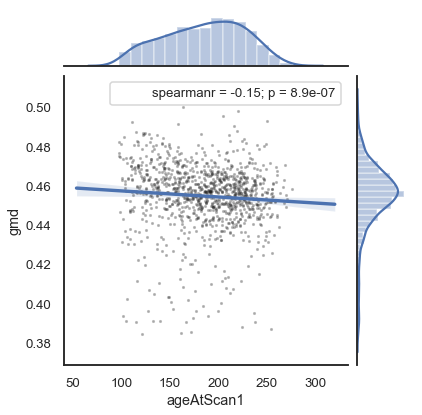

In [11]:
metric_x = 'ageAtScan1'
metric_y = 'gmd'
f = sns.jointplot(x = df[metric_x], y = df_node_mean[metric_y], kind="reg")
f.annotate(sp.stats.spearmanr)
f.plot_joint(plt.scatter, c = "k", s = 5, linewidth = 2, marker = ".", alpha = 0.3)
f.ax_joint.collections[0].set_alpha(0)

In [12]:
my_thresh = 100

In [13]:
for metric in metrics:
    x = df_node_mean.loc[:,metric].copy()
    outliers = mark_outliers(x, thresh = my_thresh)
    print(metric + ': ' + str(np.round((outliers.sum() / x.shape[0]) * 100,2)))

ct: 0.0
gmd: 0.0


A higher threshold than 3 probably makes sense but sticking with convention to avoid 'kick me' signs with reviewers.

Note, results are unaffected by setting my_thresh to 4,5, or 6

### Check frequency of outliers

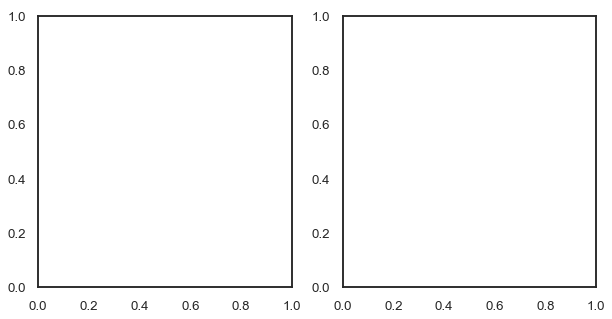

In [14]:
df_node_mask = pd.DataFrame(index = df_node.index, columns = df_node.columns)
for i, col in enumerate(df_node.columns):
    x = df_node.loc[:,col].copy()
    x_out = mark_outliers(x, thresh = my_thresh)
    df_node_mask.loc[:,col] = x_out

f, axes = plt.subplots(1,2)
f.set_figwidth(10)
f.set_figheight(5)

for i, metric in enumerate(metrics):
    if df_node_mask.filter(regex = metric).sum().any():
        sns.distplot(df_node_mask.filter(regex = metric).sum()/df_node_mask.filter(regex = metric).shape[0]*100, ax = axes[i])

In [15]:
for i, col in enumerate(df_node.columns):
    x = df_node.loc[:,col].copy()
    x_out = winsorize_outliers_signed(x, thresh = my_thresh)
    if np.any(x != x_out):
        print('winsorizing ' + col)
        df_node.loc[:,col] = x_out

In [16]:
my_str = os.environ['MODELDIR'].split('/')[-1]
my_str = my_str.split('_')[-1]
my_str

'wins'

In [17]:
df_node.shape

(1100, 801)

## Nuisance regression

### cortical thickness

In [18]:
# labels of nuisance regressors
nuis = ['mprage_antsCT_vol_TBV','averageManualRating']
print(nuis)
df_nuis = df[nuis]
df_nuis = sm.add_constant(df_nuis)

cols = df_node.filter(regex = 'ct|gmd', axis = 1).columns

mdl = sm.OLS(df_node.loc[:,cols].astype(float), df_nuis.astype(float)).fit()
y_pred = mdl.predict(df_nuis)
y_pred.columns = cols
df_node.loc[:,cols] = df_node.loc[:,cols] - y_pred

['mprage_antsCT_vol_TBV', 'averageManualRating']


/Users/lindenmp/.virtualenvs/NeuroDev_NetworkControl/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


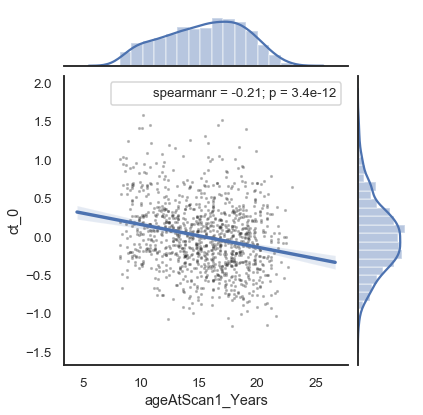

In [19]:
f = sns.jointplot(x = df['ageAtScan1_Years'], y = df_node['ct_0'], kind="reg")
f.annotate(sp.stats.spearmanr)
# f.annotate(sp.stats.pearsonr)
f.plot_joint(plt.scatter, c = "k", s = 5, linewidth = 2, marker = ".", alpha = 0.3)
f.ax_joint.collections[0].set_alpha(0)

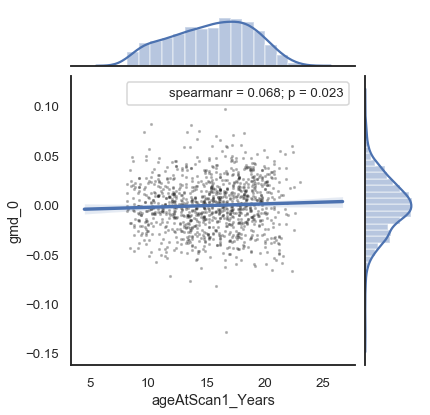

In [20]:
f = sns.jointplot(x = df['ageAtScan1_Years'], y = df_node['gmd_0'], kind="reg")
f.annotate(sp.stats.spearmanr)
# f.annotate(sp.stats.pearsonr)
f.plot_joint(plt.scatter, c = "k", s = 5, linewidth = 2, marker = ".", alpha = 0.3)
f.ax_joint.collections[0].set_alpha(0)

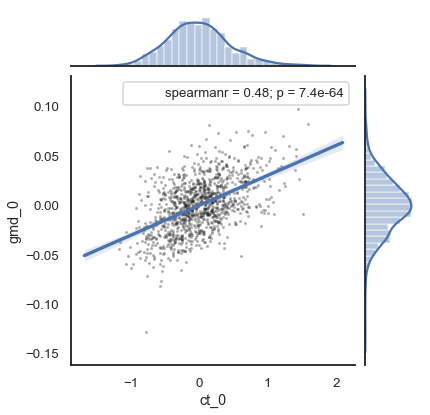

In [21]:
f = sns.jointplot(x = df_node['ct_0'], y = df_node['gmd_0'], kind="reg")
f.annotate(sp.stats.spearmanr)
# f.annotate(sp.stats.pearsonr)
f.plot_joint(plt.scatter, c = "k", s = 5, linewidth = 2, marker = ".", alpha = 0.3)
f.ax_joint.collections[0].set_alpha(0)

In [22]:
df_node.head()

,,squeakycleanExclude,ct_0,ct_1,ct_2,ct_3,ct_4,ct_5,ct_6,ct_7,ct_8,...,gmd_390,gmd_391,gmd_392,gmd_393,gmd_394,gmd_395,gmd_396,gmd_397,gmd_398,gmd_399
bblid,scanid,,,,,,,,,,,,,,,,,,,,,
81287,2738,0,-0.425789,-0.176205,-0.234661,-0.082965,-0.384164,-0.186231,-0.462758,-0.539165,-0.496939,...,0.018027,0.002606,0.015247,0.018425,0.011052,0.026700,0.007263,-0.003814,-0.043487,-0.032724
80680,2739,1,-0.153242,0.050253,-0.144155,-0.146309,0.207865,-0.116329,0.213264,-0.277467,0.274743,...,-0.008272,0.016703,0.009377,-0.022462,-0.003901,-0.038104,-0.063788,0.011916,0.024257,-0.011738
81754,2740,1,0.071390,0.567618,0.704850,0.412302,0.395433,0.358266,0.720650,-0.273715,0.130218,...,-0.052667,-0.020448,-0.039573,-0.017931,-0.015323,-0.011086,-0.020836,0.016543,0.059821,-0.017255
81903,2749,0,0.022296,-0.034686,0.166078,-0.048055,-0.068252,-0.025995,-0.318632,0.340474,0.342959,...,0.020290,0.005134,-0.012267,-0.003560,0.005315,-0.000812,0.012168,0.020843,0.070906,0.011114
81043,2750,0,-0.271351,-0.607769,0.296730,-0.490496,-0.105436,-0.288243,-0.592105,0.519973,0.353459,...,0.025312,0.019765,0.003972,0.010837,-0.004926,-0.009935,0.013234,0.024916,-0.043443,-0.006091


In [23]:
df_node_mean = pd.DataFrame(index = df_node.index, columns = metrics)
for metric in metrics:
    df_node_mean[metric] = df_node.filter(regex = metric, axis = 1).mean(axis = 1)

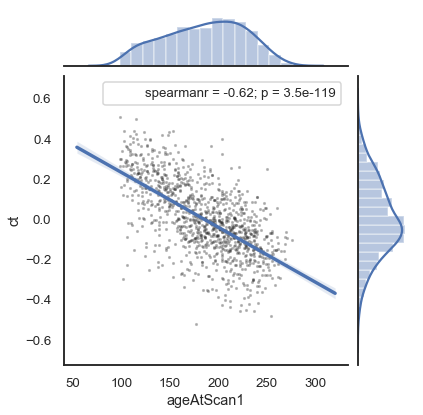

In [24]:
metric_x = 'ageAtScan1'
metric_y = 'ct'
f = sns.jointplot(x = df[metric_x], y = df_node_mean[metric_y], kind="reg")
f.annotate(sp.stats.spearmanr)
f.plot_joint(plt.scatter, c = "k", s = 5, linewidth = 2, marker = ".", alpha = 0.3)
f.ax_joint.collections[0].set_alpha(0)

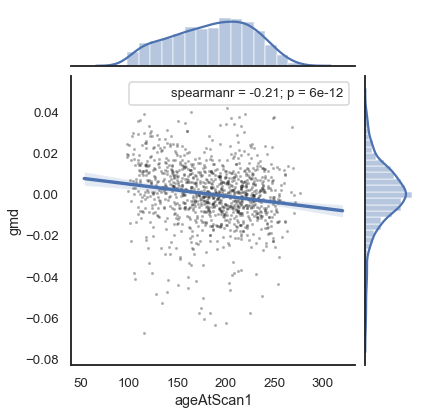

In [25]:
metric_x = 'ageAtScan1'
metric_y = 'gmd'
f = sns.jointplot(x = df[metric_x], y = df_node_mean[metric_y], kind="reg")
f.annotate(sp.stats.spearmanr)
f.plot_joint(plt.scatter, c = "k", s = 5, linewidth = 2, marker = ".", alpha = 0.3)
f.ax_joint.collections[0].set_alpha(0)

In [26]:
df_node.isna().any().any()

False

## Save out

In [27]:
# Save out
df_node.to_csv(os.path.join(os.environ['MODELDIR'], 'df_node_clean.csv'))